# 9.2 微调

In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 9.2.1 热狗识别
### 9.2.1.1 获取数据集

In [2]:
data_dir = '/S1/CSCL/tangss/Datasets'
os.listdir(os.path.join(data_dir, "hotdog"))

['train', 'test']

In [3]:
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))

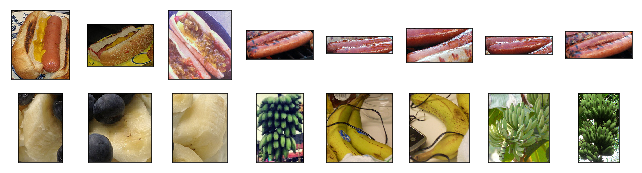

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])

### 9.2.1.2 定义和初始化模型

In [6]:
pretrained_net = models.resnet18(pretrained=True)

In [7]:
print(pretrained_net.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [8]:
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net.fc)

Linear(in_features=512, out_features=2, bias=True)


In [9]:
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())

lr = 0.01
optimizer = optim.SGD([{'params': feature_params},
                       {'params': pretrained_net.fc.parameters(), 'lr': lr * 10}],
                       lr=lr, weight_decay=0.001)

### 9.2.1.3 微调模型

In [10]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs),
                            batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs),
                           batch_size)
    loss = torch.nn.CrossEntropyLoss()
    d2l.train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [11]:
train_fine_tuning(pretrained_net, optimizer)

training on  cuda
epoch 1, loss 3.1183, train acc 0.731, test acc 0.932, time 41.4 sec
epoch 2, loss 0.6471, train acc 0.829, test acc 0.869, time 25.6 sec
epoch 3, loss 0.0964, train acc 0.920, test acc 0.910, time 24.9 sec
epoch 4, loss 0.0659, train acc 0.922, test acc 0.936, time 25.2 sec
epoch 5, loss 0.0668, train acc 0.913, test acc 0.929, time 25.0 sec


In [12]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer)

training on  cuda
epoch 1, loss 2.6686, train acc 0.582, test acc 0.556, time 25.3 sec
epoch 2, loss 0.2434, train acc 0.797, test acc 0.776, time 25.3 sec
epoch 3, loss 0.1251, train acc 0.845, test acc 0.802, time 24.9 sec
epoch 4, loss 0.0958, train acc 0.833, test acc 0.810, time 25.0 sec
epoch 5, loss 0.0757, train acc 0.836, test acc 0.780, time 24.9 sec
